# Paso 3 - Modelado (Logistic Regression)

**Celda 3.1 - Cargar librerías y datasets**

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
X_train = pd.read_parquet("../artifacts/X_train.parquet")
X_test  = pd.read_parquet("../artifacts/X_test.parquet")
y_train = pd.read_parquet("../artifacts/y_train.parquet")["TARGET"]
y_test  = pd.read_parquet("../artifacts/y_test.parquet")["TARGET"]

X_train.shape, X_test.shape

((246008, 210), (61503, 210))

**Celda 3.2 - Entrenar Regresión Logística**

In [3]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)

log_reg.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


**Celda 3.2.1 - Guardar modelo entrenado**

In [9]:
import joblib

joblib.dump(log_reg, "../artifacts/log_reg_model.joblib")
joblib.dump(0.30, "../artifacts/decision_threshold.joblib")

print("Modelo guardado correctamente en artifacts/")

Modelo guardado correctamente en artifacts/


**Celda 3.3 - Evaluación inicial del modelo**

In [4]:
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       0.94      0.59      0.73     56538
           1       0.11      0.57      0.18      4965

    accuracy                           0.59     61503
   macro avg       0.53      0.58      0.46     61503
weighted avg       0.87      0.59      0.68     61503

ROC-AUC: 0.6137333651525161


**Celda 3.4 - Comentario para el informe**

### Modelo de Regresión Logística

Se entrenó un modelo de **Regresión Logística** para predecir el incumplimiento de pago de clientes.
Debido al fuerte desbalance de clases presente en la variable objetivo, se utilizó el parámetro
`class_weight="balanced"`.

El modelo fue evaluado mediante métricas de clasificación y el área bajo la curva ROC (ROC-AUC),
la cual es adecuada para problemas de clasificación binaria con clases desbalanceadas.

**Celda 3.5 - Matriz de Confusión**

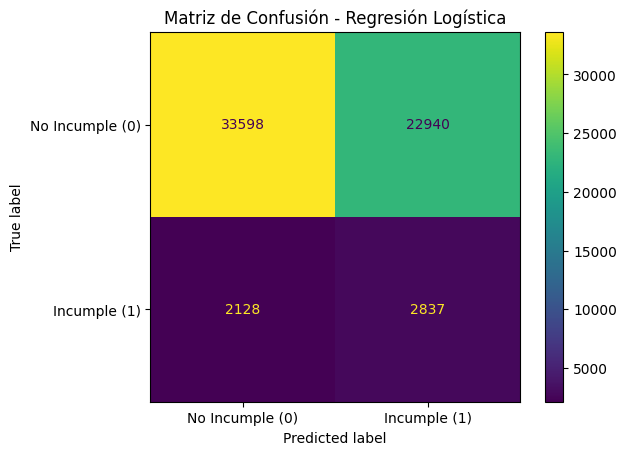

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Incumple (0)", "Incumple (1)"]
)

disp.plot()
plt.title("Matriz de Confusión - Regresión Logística")
plt.show()

**Comentario 3.5**

### Matriz de Confusión

La matriz de confusión permite observar el desempeño del modelo en términos de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos.  
Dado el desbalance de clases, el enfoque del modelo prioriza detectar la clase minoritaria (incumplimiento), lo cual aumenta el recall de la clase 1 pero genera más falsos positivos.

**Celda 3.6 - Curva ROC**

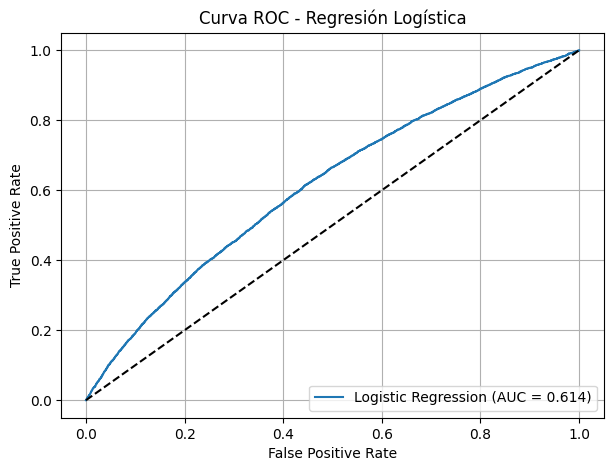

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Regresión Logística")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Comentario 3.6**

### Curva ROC

La curva ROC evalúa la capacidad del modelo para discriminar entre clientes que incumplen y no incumplen.  
El área bajo la curva (ROC-AUC) resume el desempeño global de discriminación, siendo especialmente útil en escenarios con clases desbalanceadas.

**Celda 3.7 - Ajuste de umbral (Threshold tuning)**

Objetivo

Evaluar distintos umbrales de decisión para mejorar el recall de la clase minoritaria (incumplimiento), aceptando un mayor número de falsos positivos.

**Celda 3.7.1 - Probar umbral distinto a 0.5**

In [7]:
import numpy as np
from sklearn.metrics import classification_report

# Definir nuevo umbral
threshold = 0.30

# Aplicar umbral a las probabilidades
y_pred_threshold = (y_prob >= threshold).astype(int)

print(f"Resultados con umbral = {threshold}")
print(classification_report(y_test, y_pred_threshold))

Resultados con umbral = 0.3
              precision    recall  f1-score   support

           0       0.95      0.04      0.07     56538
           1       0.08      0.98      0.15      4965

    accuracy                           0.11     61503
   macro avg       0.52      0.51      0.11     61503
weighted avg       0.88      0.11      0.08     61503



**Celda 3.7.2 - Comparación conceptual**

### Ajuste de umbral de decisión

Dado el desbalance de clases, se evaluó un umbral de decisión distinto al valor por defecto (0.5).
Al reducir el umbral a 0.30, el modelo incrementa su capacidad de detección de clientes incumplidores (mayor recall de la clase 1), a costa de un aumento en los falsos positivos.

Este ajuste es adecuado en contextos donde el costo de no detectar un incumplimiento es mayor que el costo de una falsa alerta.

**Celda 3.8 - Conclusiones del Modelo**

### Conclusiones del Modelo

El modelo de Regresión Logística permitió identificar patrones asociados al incumplimiento de pago, logrando una capacidad moderada de discriminación entre clientes que incumplen y no incumplen.

Debido al fuerte desbalance de clases, se priorizó el recall de la clase minoritaria mediante el uso de `class_weight="balanced"` y el ajuste del umbral de decisión, logrando detectar la mayoría de los clientes incumplidores.

El modelo es interpretable y adecuado como línea base para sistemas de apoyo a la toma de decisiones en contextos de riesgo crediticio.

**Celda 3.9 - Limitaciones del Modelo**

### Limitaciones del Modelo

- El modelo presenta un número elevado de falsos positivos, lo que puede generar alertas innecesarias.
- La capacidad predictiva global (ROC-AUC ≈ 0.61) es moderada.
- La Regresión Logística asume relaciones lineales entre variables y el log-odds del evento.
- No se evaluaron modelos más complejos que puedan capturar relaciones no lineales.

Estas limitaciones abren la posibilidad de explorar modelos más avanzados en futuras etapas.